In [1]:
#setup:
import matplotlib.pyplot as plt

plt.rc('font',size=14)
plt.rc('axes',labelsize=14,titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

In [1]:
# Download the data:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True,exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path("datasets/housing/housing.csv"))


In [2]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
# save fig function:
images_path = Path() / "images" / "CH02(END-2-END-PROJECT)"
images_path.mkdir(parents=True,exist_ok=True)

def savefig(fig_id,tight_layout=True,fig_extension="png",resolution=300):
    path = images_path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)


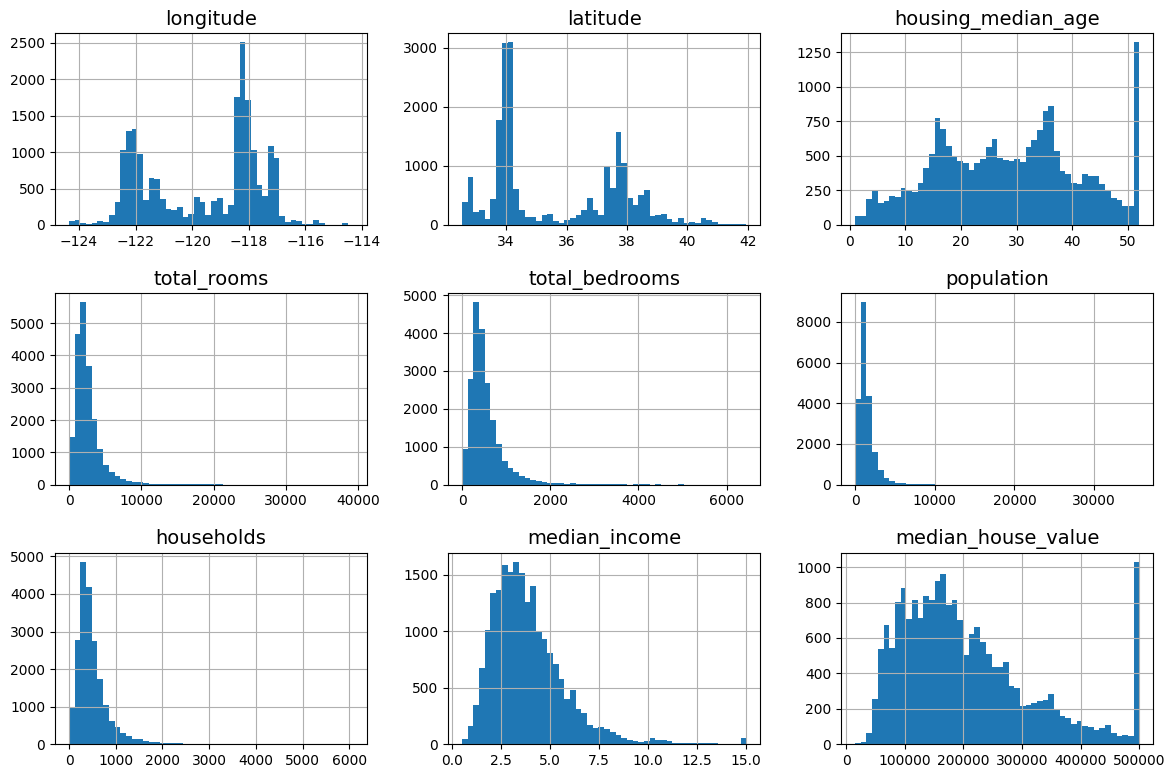

In [8]:
# data visualization
housing.hist(bins=50, figsize=(12,8))
savefig("attribute_histogram_plots")
plt.show() 

In [9]:
# create a test set:
import numpy as np

def shuffle_and_split_data(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set , test_set = shuffle_and_split_data(housing,0.2)
len(train_set),len(test_set)
    

(16512, 4128)

In [10]:
np.random.seed(42) # to make the notebook reproducable though it can be changed with other sources of variations

In [11]:
# The split is based on the identifier rather than random shuffling, ensuring rows are consistently assigned to the same set.
# important in incremental learning models.

from zlib import crc32 #checksum ( a hash function from zlib)

def is_id_in_test_set(identifier,test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index() # adds an index col
train_set, test_set = split_data_with_id_hash(housing_with_id,0.2,"index")

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id,0.2,"id")

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing,test_size=0.2, random_state=42)

In [15]:
test_set["total_bedrooms"].isnull().sum()

44

In [16]:
""" To find the probability that a random sample of 1000 people conatins less than 48.5% female or more tha 53.5% female when
the population's female ratio is 51.5%, we use  the binomial distribution. The cdf() method of the binomial distribution gives
us the probability that the number of females will be equal or less than the given value."""

# There total 10.7% proba of this sample being a bad sample
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size,ratio_female).cdf(485-1)
proba_too_large = 1 - binom(sample_size,ratio_female).cdf(535)
print("proba_too_small",proba_too_small)
print("proba_too_large",proba_too_large)


proba_too_small 0.0468450218634498
proba_too_large 0.06052296344584962


In [17]:
# another way to  estimate the proba of bad sample
np.random.seed(42)


samples = (np.random.rand(100_000,sample_size) < ratio_female).sum(axis=1)
((samples<485)|(samples>535)).mean()

0.1071

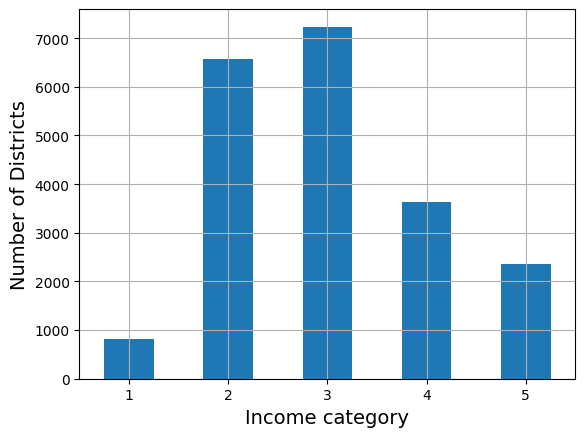

In [18]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0,1.5,3.0,4.5,6.0,np.inf],
                               labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of Districts")
plt.show()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index,test_index in splitter.split(housing,housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]

In [20]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [ ]:
# income_cat proportions:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing,
                                       test_size=0.2,
                                       random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"

# difference relative to overall props
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"]-1) 

compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"]-1)

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

# Discover and Visulaize the data to gain insights:

In [24]:
housing = strat_train_set.copy()

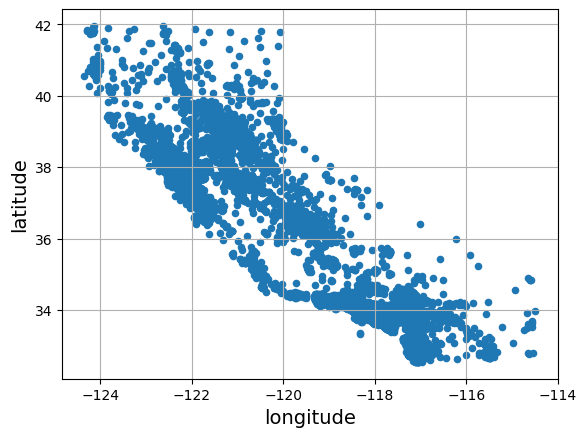

In [25]:
# Visualizing Geographical data:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

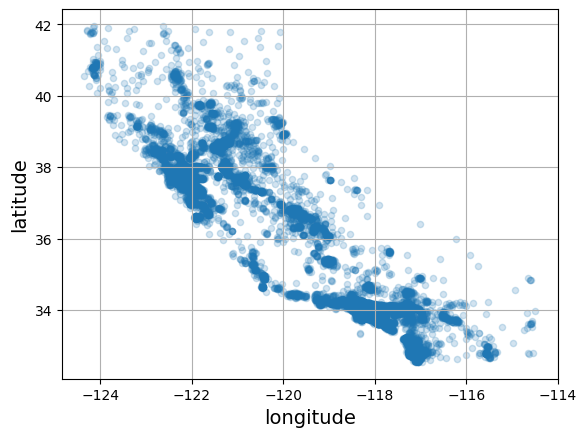

In [26]:
# adding some transparency using alpha:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

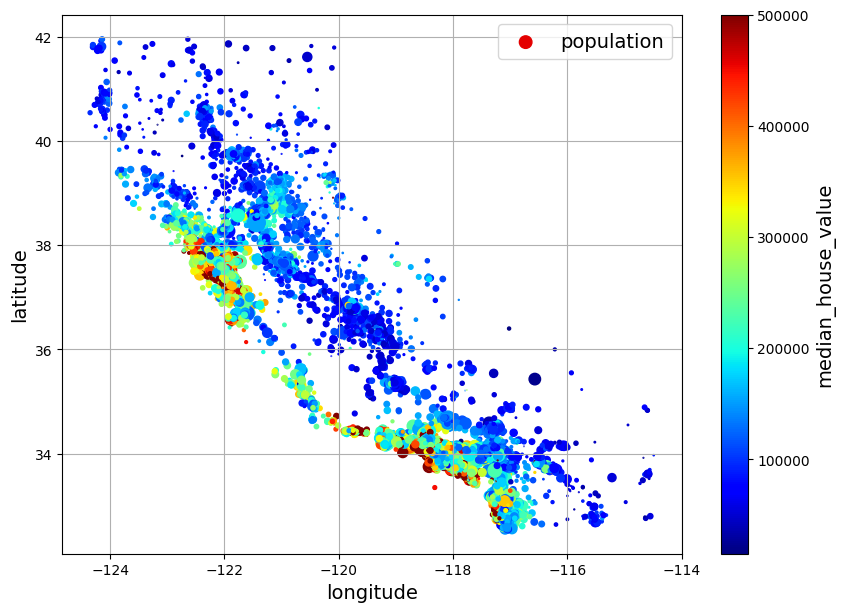

In [26]:
# adding some colormap and legend and other features of plot
# The argument sharex=False fixes a display bug: without it, the x-axis values and label are not displayed.
housing.plot(kind="scatter",x="longitude",y="latitude",
             grid=True, s=housing["population"]/100,
             label="population", c="median_house_value",
             cmap="jet",colorbar=True,
             legend=True, sharex=False, figsize=(10,7))
plt.show()

# LOOking for correlations:

In [27]:
# Note: since Pandas 2.0.0, the numeric_only argument defaults to False, so we need to set it explicitly to True to avoid an error.
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

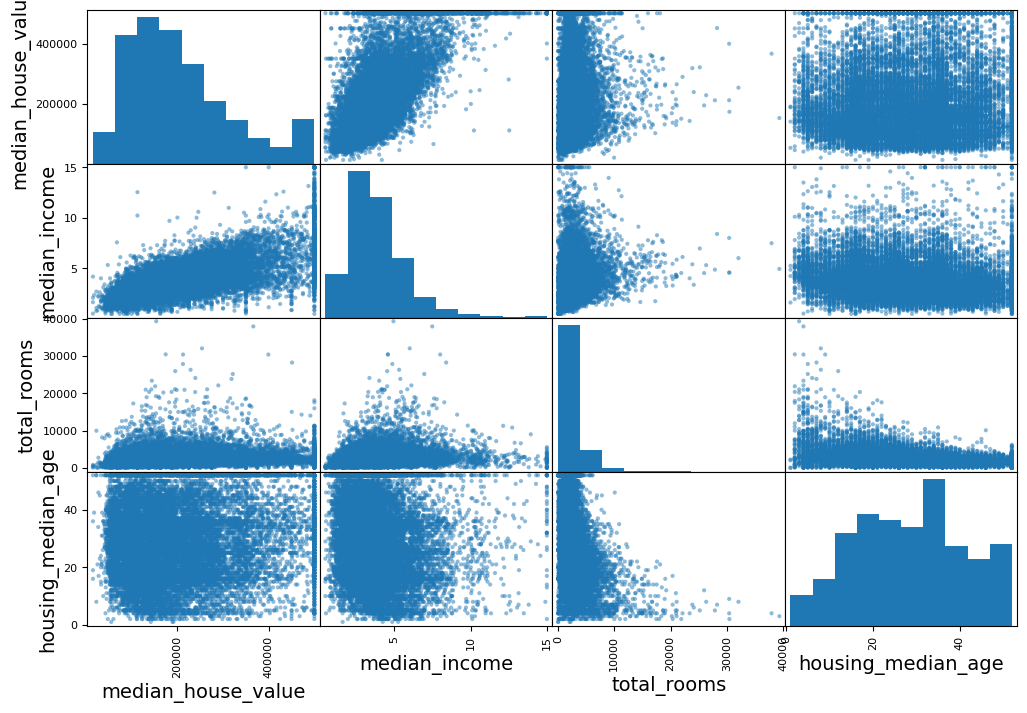

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

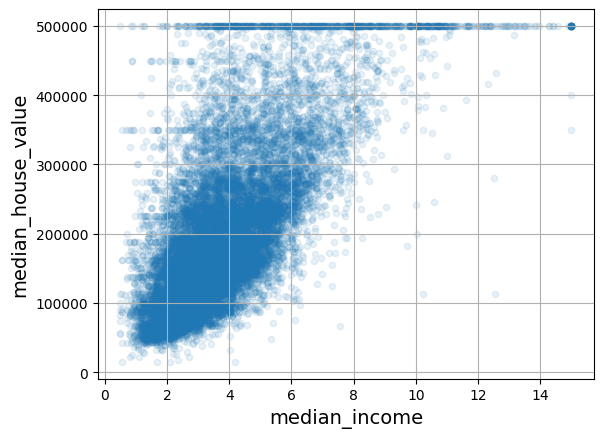

In [30]:
housing.plot(kind="scatter",
             x="median_income",
             y="median_house_value",
             alpha=0.1,
             grid=True
)
# the lines like above in below graph are known as spikes/outliers.

# Experimenting with attributes combinations:

In [31]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [32]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the data for ML algos:

In [33]:
# Let's revert to the original training set and separate the target (note that strat_train_set.drop() creates a copy of strat_train_set without the column,
#  it doesn't actually modify strat_train_set itself, unless you pass inplace=True):
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [34]:
# Data cleaning:

# 1) Handling missing values (we have 3 ways):

housing.dropna(subset=["total_bedrooms"],inplace=True) # option 1

housing.drop("total_bedrooms",axis=1) # option 2

median = housing["total_bedrooms"].median() 
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median) # option 3

In [35]:
"""For each option, we'll create a copy of housing and work on that copy to avoid breaking housing"""
null_rows_idx = housing.isnull().any(axis=1)

# options 1
housing_option1 = housing.copy()

housing_option1 = housing_option1.dropna(subset=["total_bedrooms"]) 

housing_option1.loc[null_rows_idx].head()

# option 2
housing_option2 = housing.copy()

housing_option2 = housing_option2.drop("total_bedrooms",axis=1)

housing_option2.loc[null_rows_idx].head()

# option 3
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()

housing_option3["total_bedrooms"] = housing_option3["total_bedrooms"].fillna(median)

housing_option3.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [36]:
# 2) Imputing
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

"""Separating out the numerical attributes to use the "median" strategy (as it cannot be calculated on text attributes like ocean_proximity)"""
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [38]:
# Check that this is the same as manually computing the median of each attribute:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [39]:
# Transform the training set:
X = imputer.transform(housing_num)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [40]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [41]:
imputer.strategy

'median'

In [42]:
# now let's drop some outliers:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [43]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

In [44]:
# ***drop the outliers rows:
# housing = housing.iloc[outlier_pred==1]
# housing_labels = housing_labels.iloc[outlier_pred==1]

In [28]:
# Handling Text and categorical attributes:

# 1) preprocess the categorical input feature, ocean_proximity:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

In [46]:
# Ordinal Encoding
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
housing_cat_encoded = oe.fit_transform(housing_cat)

In [47]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [48]:
oe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [29]:
# Ohe:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
ohe = cat_encoder.fit_transform(housing_cat)

In [31]:
ohe

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [51]:
"""By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:"""
ohe.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [52]:
"""Alternatively, you can set sparse_output=False when creating the OneHotEncoder (note: the sparse hyperparameter was renamned to sparse_output in Scikit-Learn 1.2)"""
cat_encoder = OneHotEncoder(sparse_output=False)
ohe = cat_encoder.fit_transform(housing_cat)
ohe

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [53]:
df_test = pd.DataFrame({"ocean_proximity":["INLAND","NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [54]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [55]:
df_test_unknown = pd.DataFrame({"ocean_proximity":["<2H OCEAN","ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [56]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [57]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [58]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [59]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [60]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


In [61]:
# Feature Scaling:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [62]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

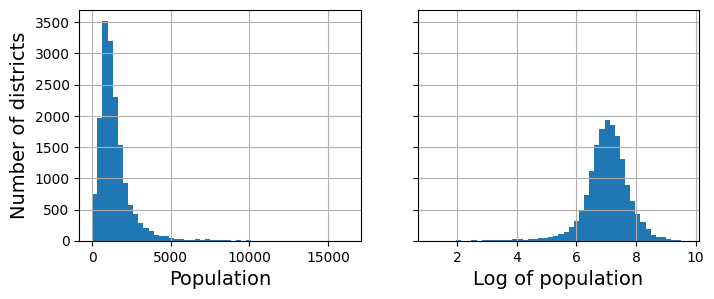

In [63]:
# Graph of Populations vs no. of districts and log of population vs. no. of districts
fig, axes = plt.subplots(1,2,figsize=(8,3),sharey=True)
housing["population"].hist(ax=axes[0],bins=50)
housing["population"].apply(np.log).hist(ax=axes[1],bins=50)
axes[0].set_xlabel("Population")
axes[1].set_xlabel("Log of population")
axes[0].set_ylabel("Number of districts")
plt.show()


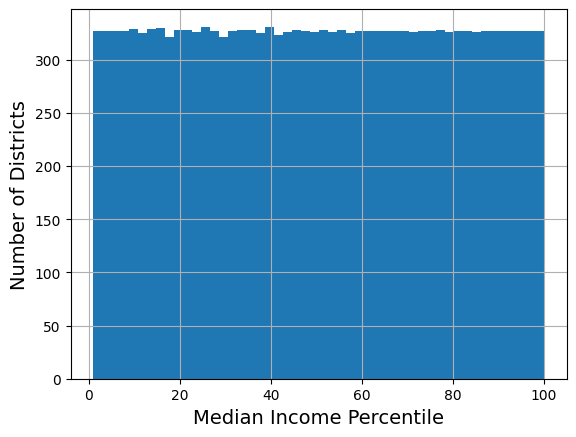

'\n# Note: incomes below the 1st percentile are labeled 1, and incomes above the\n# 99th percentile are labeled 100. This is why the distribution below ranges\n# from 1 to 100 (not 0 to 100).'

In [64]:
# replacing each value with it's percentile:
percentiles = [np.percentile(housing["median_income"],p) for p in range(1,100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf]+percentiles + [np.inf],
                                 labels = range(1,100+1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median Income Percentile")
plt.ylabel("Number of Districts")
plt.show()
"""
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100)."""

In [65]:
# Using rbf kernel to find similarity matrix between housing_median_age and 35
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]],[[35]],gamma=0.1)

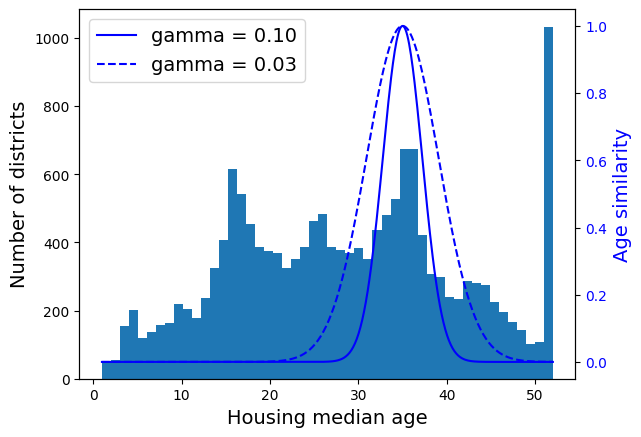

In [66]:
# visulaizing the similarity matrix:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1,1)

gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages,[[35]],gamma=gamma1)
rbf2 = rbf_kernel(ages,[[35]],gamma=gamma2)

fig,ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"],bins=50)

ax2 = ax1.twinx() #create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages,rbf1,color=color,label="gamma = 0.10")
ax2.plot(ages,rbf2,color=color,label="gamma = 0.03",linestyle="--")
ax2.tick_params(axis='y',labelcolor = color)
ax2.set_ylabel("Age similarity",color = color)


plt.legend(loc="upper left")
plt.show()


In [67]:
# apply LinearRegression model
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]],scaled_labels[:16344])
some_new_data = housing[["median_income"]].iloc[:5]

scaled_preds = model.predict(some_new_data)
preds = target_scaler.inverse_transform(scaled_preds)

preds

array([[205826.51165655],
       [206871.92838514],
       [205914.12548803],
       [205869.25714239],
       [206201.4191825 ]])

# Custom Transformers:


In [68]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log,inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [69]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]],
                                                   gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])


In [70]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [71]:
sf_coords = 37.7749,-122.41
sf_transformer  = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[sf_coords],
                                                   gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude","longitude"]])

In [72]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [73]:
ratio_transformer = FunctionTransformer(lambda X:X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1.,2.],[3.,4.]]))

array([[0.5 ],
       [0.75]])

In [74]:
# using TransformerMixin and BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator,TransformerMixin):
    def __init__(self,with_mean=True): # no *args or **kwargs !
        self.with_mean = with_mean

    def fit(self,X,y=None): # y is required even though we don't use it
        X = check_array(X) #checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] #every estimator stores this in fit()
        return self # always return self!
    
    def transform(self,X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [75]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,n_clusters=10,gamma=1.0,random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self,X,y=None,sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self
    
    def transform(self,X):
        return rbf_kernel(X,self.kmeans_.cluster_centers_ , gamma=self.gamma)
    
    def get_features_names_out(self,names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [76]:
cluster_simil = ClusterSimilarity(n_clusters=10,gamma=1,random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight = housing_labels[:16344])

In [77]:
similarities[:3].round(2)

array([[0.85, 0.  , 0.08, 0.  , 0.  , 0.  , 0.74, 0.14, 0.  , 0.  ],
       [0.  , 0.95, 0.  , 0.03, 0.  , 0.12, 0.  , 0.  , 0.31, 0.  ],
       [0.51, 0.  , 0.44, 0.  , 0.  , 0.  , 0.76, 0.27, 0.  , 0.  ]])

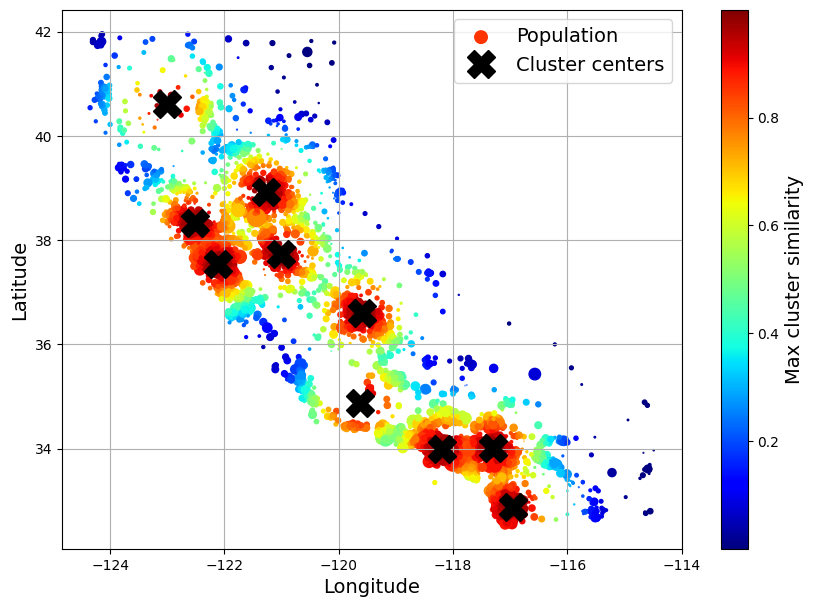

In [78]:
# visualizing clusters
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population", "median_house_value":"Median house value (USD)"
})

housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude",y="Latitude",
                     grid=True, s=housing_renamed["Population"]/100, label="Population",
                     c="Max cluster similarity", cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10,7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:,1],
         cluster_simil.kmeans_.cluster_centers_[:,0],
         linestyle="",color="black",marker="X",markersize=20,
         label="Cluster centers")

plt.legend(loc="upper right")
plt.show()

# Transformation Pipelines:

In [79]:
# 1-way
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ("impute",SimpleImputer(strategy='median')),
    ("standardize",StandardScaler()),
])


In [80]:
# 2-way:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [81]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.36,  0.14,  1.4 , -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [82]:
def monkey_patch_get_signature_names_out():
    """Monkey Patch some claases which did not handle get_feature_names_out()
    correctly in sklean.1.0"""
    from inspect import Signature,signature,Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline,Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer,"get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_features_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args,feature_names_out=None,**kwargs):
            orig_sig.bind(*args,**kwargs)
            orig_init(*args,**kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out",Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self,names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self,names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self,names)
        
        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [83]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index = housing_num.index
)

df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.422634,1.013124,1.860687,0.310661,1.359094,0.137572,1.395732,-0.937557
14973,0.596681,-0.702274,0.907526,-0.308789,-0.436356,-0.693276,-0.373537,1.171380


In [84]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [85]:
num_pipeline[1]

StandardScaler()

In [86]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [87]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [88]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [89]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",cat_pipeline,cat_attribs),
])

In [90]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [91]:
housing_prepared = preprocessing.fit_transform(housing)

In [92]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns = preprocessing.get_feature_names_out(),
    index=housing.index
)

housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.422634,1.013124,1.860687,0.310661,1.359094,0.137572,1.395732,-0.937557,0.0,0.0,0.0,1.0,0.0
14973,0.596681,-0.702274,0.907526,-0.308789,-0.436356,-0.693276,-0.373537,1.171380,1.0,0.0,0.0,0.0,0.0


In [93]:
from sklearn.preprocessing import FunctionTransformer
def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["return"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio,feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline  = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10,gamma=1.,random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

preprocessing = ColumnTransformer([
   ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [94]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16344, 24)

# select and train a model

In [95]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing,LinearRegression())
lin_reg.fit(housing,housing_labels[:16344])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024836A93B10>)])),
                ('linearregression', LinearRegression())])

In [96]:
#try preproceessing pipeline on a few training instances and compare with actual values
housing_preds = lin_reg.predict(housing)
housing_preds[:5].round(-2) # -2 = rounded to the nearest hundred

array([206200., 206700., 210200., 205000., 210600.])

In [97]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [98]:
error_ratios = housing_preds[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio: .1f}%" for ratio in error_ratios]))

-55.0%, -57.3%,  106.7%,  113.3%, -41.8%


In [99]:
from sklearn.metrics import mean_squared_error
lin_rmse = np.sqrt(mean_squared_error(housing_labels[:16344],housing_preds))
lin_rmse

115244.52927893531

In [100]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing,housing_labels[:16344])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024836A93B10>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [101]:
housing_preds_tree = tree_reg.predict(housing)
tree_rmse = np.sqrt(mean_squared_error(housing_labels[:16344],housing_preds_tree))
tree_rmse

0.0

# Better Evaluation Using CV

In [102]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg,housing,housing_labels[:16344],
                              scoring="neg_root_mean_squared_error",cv=3)


In [103]:
pd.Series(tree_rmses).describe()

count         3.000000
mean     166227.500042
std         128.522028
min      166087.264439
25%      166171.415007
50%      166255.565576
75%      166297.617844
max      166339.670113
dtype: float64

In [104]:
lin_rmses = -cross_val_score(lin_reg,housing,housing_labels[:16344],
                             scoring="neg_root_mean_squared_error",cv=3)
pd.Series(lin_rmses).describe()

count         3.000000
mean     115491.687705
std        1417.366258
min      114434.066541
25%      114686.448518
50%      114938.830494
75%      116020.498287
max      117102.166080
dtype: float64

In [105]:
# warning: long time run
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg,housing,housing_labels[:16344],
                                scoring="neg_root_mean_squared_error",cv=3)

In [106]:
pd.Series(forest_rmses).describe()

count         3.000000
mean     118266.521614
std        1313.929753
min      116929.923300
25%      117621.510288
50%      118313.097276
75%      118934.820771
max      119556.544266
dtype: float64

In [109]:
# let's compare this rmse measured using cv (the "validation error") with the RMSE measured on the training set (the "training error"):
forest_reg.fit(housing,housing_labels[:16344])
housing_predictions = forest_reg.predict(housing)
forest_rmse = np.sqrt(mean_squared_error(housing_labels[:16344],housing_predictions))


# Fine-Tune Model

In [ ]:
# Grid search

# long time run warning
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing",preprocessing),
    ("rf",RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters':[5,8,10],
     'rf__max_features':[4,6,8]},
    {'preprocessing__geo__n_clusters':[10,15],
     'rf__max_features':[6,8,10]},
]
grid_search = GridSearchCV(full_pipeline,param_grid,cv=3,scoring="neg_root_mean_squared_error")
grid_search.fit(housing,housing_labels)

In [ ]:
#get list of hyperparams available for tuning
print(str(full_pipeline.get_params().keys())[:1000] + "...")


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
#let's look at each hyperparameter combination tested during grid search
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score',ascending=False,inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_rf__max_features","split0_test_score",
                 "split1_test_score","split2_test_score","mean_test_score"]]

score_cols = ["split0","split1","split2","mean_test_rmse"]
cv_res.columns = ["n_clusters","max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

In [114]:
# Randomized search

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
# warning: long runtime
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters':randint(low=3,high=50),
                  'rf__max_features':randint(low=2,high=20)}

full_pipeline = Pipeline([
    ("preprocessing",preprocessing),
    ("rf",RandomForestRegressor(random_state=42)),
])

rnd_search = RandomizedSearchCV(
    full_pipeline,param_distributions=param_distribs,
    n_iter = 10,cv=3,scoring="neg_root_mean_squared_error", random_state=42
)

rnd_search.fit(housing,housing_labels[:16344])

In [ ]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by='mean_test_score',ascending=False,inplace=True)
cv_res = cv_res[[
    "param_preprocessing__geo__n_clusters",
    "param_rf__max_features",
    "split0_test_score",
    "split1_test_score", "split2_test_score","mean_test_score"
]]

cv_res.columns = ["n_clusters","max_features"].round().astype(np.int64)
cv_res.head()

# how to choose the sampling distribution for a hyperparameter

scipy.stats.randint(a, b+1): for hyperparameters with discrete values that range from a to b, and all values in that range seem equally likely.
scipy.stats.uniform(a, b): this is very similar, but for continuous hyperparameters.
scipy.stats.geom(1 / scale): for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
scipy.stats.expon(scale): this is the continuous equivalent of geom. Just set scale to the most likely value.
scipy.stats.loguniform(a, b): when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.

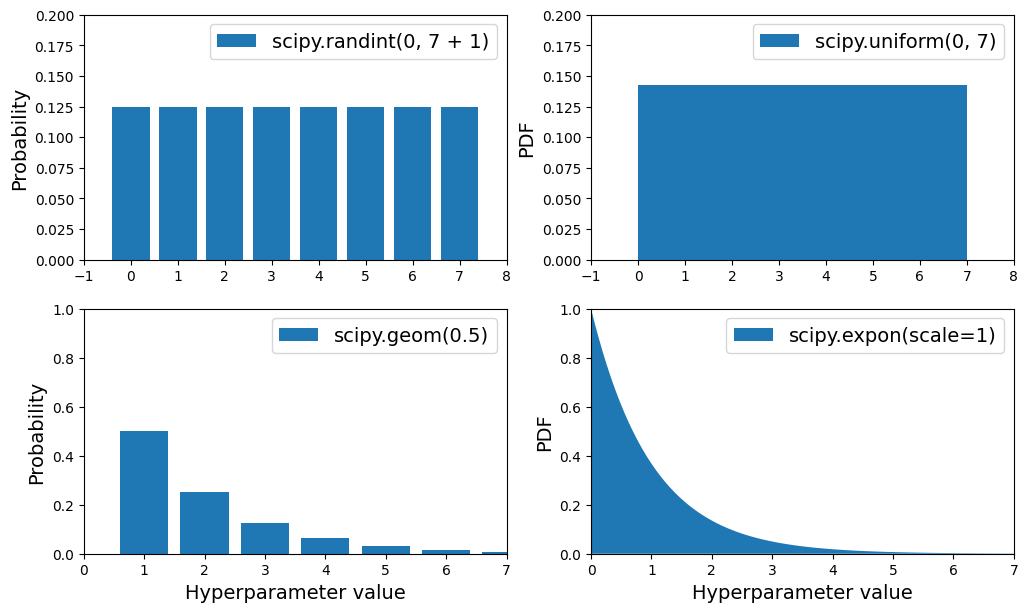

In [111]:
"""
plots of the proba mass functions(for discrete vars), and proba density functions(for continuous vars) for randint(), uniform(), geom() and expon():
"""
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for expon() and loguniform() (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter scales. You can see that expon() favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But loguniform() does not favor any scale, they are all equally likely

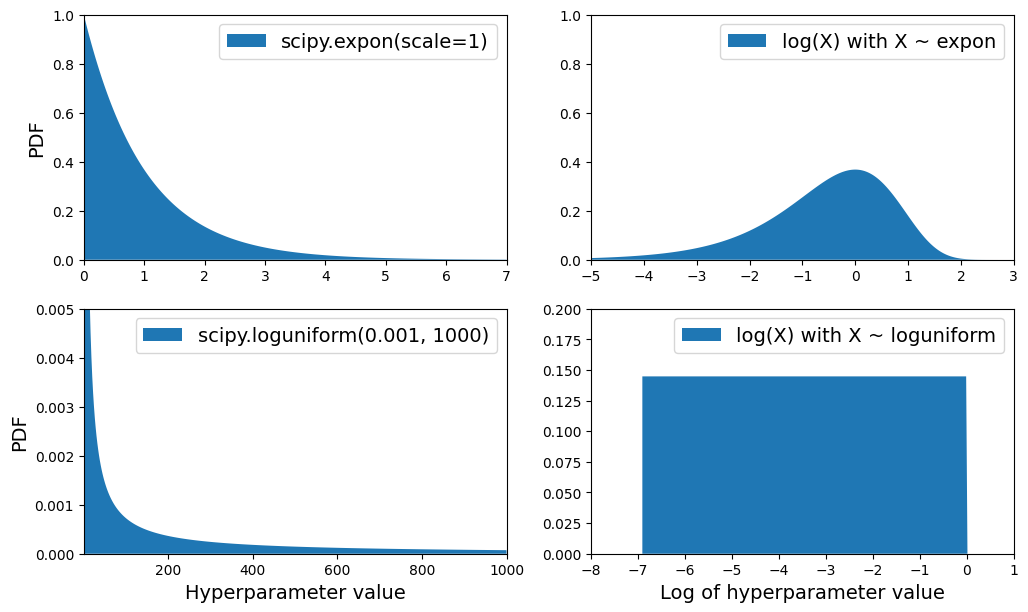

In [112]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

# Analyze the best models and their errors

In [ ]:
final_model = rnd.search.best_estimator_
feature_importances = final_model["rf"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)


# Evaluate your system on test set

In [ ]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_preds = final_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test,final_preds))
final_rmse

In [ ]:
# computing 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (final_preds - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


In [ ]:
# computing the interval manually
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1+confidence)/2, df=m-1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean-tmargin),np.sqrt(mean+tmargin)

In [ ]:
# Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference

# computing confidence interval using z-score
zscore = stats.norm.ppf((1+confidence)/2)
zmargin = zscore * squared_errors.std(ddof=1)/np.sqrt(m)
np.sqrt(mean-zmargin),np.sqrt(mean+zmargin)

# model persistence using joblib

In [ ]:
import joblib
joblib.dump(final_model,"my_california_housing_model.pkl")

In [ ]:
"""Now you can deploy this model to production. For example, the following code could be a script that would run in production"""
import joblib

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

#class CLusterSimilarity(BaseEstimator,TransformerMixin):
# [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]
preds = final_model_reloaded.predict(new_data)

preds